# Finetuning with MNLI

After finding our best model, follow this notebook to finetune the model with MNLI dataset

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle as pkl
import datetime
import random
import numpy as np
import torch
import os
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import load_data
from models import *
from training import *

In [2]:
HIDDEN_DIM = 100
MAX_SENTENCE_LENGTH = 30
BATCH_SIZE = 32
NUM_CLASS = 20
LEARNING_RATE = 0.005
NUM_EPOCHES = 10

DATA_PATH = 'data/'

### Initialize MNLI data

In [3]:
mnli_train = pd.read_csv(DATA_PATH + "mnli_train.tsv", sep='\t')
mnli_val = pd.read_csv(DATA_PATH + "mnli_val.tsv", sep='\t')

mnli_train_data = load_data.prepare_data(mnli_train)
mnli_val_data = load_data.prepare_data(mnli_val)

print ("Train dataset size is {}".format(len(mnli_train_data)))
print ("Val dataset size is {}".format(len(mnli_val_data)))

Train dataset size is 20000
Val dataset size is 5000


In [4]:
all_genre = mnli_train_data.genre.unique().tolist()
all_genre

['telephone', 'fiction', 'slate', 'government', 'travel']

## Initialize and load our best model (both NN and LR)
#### LR

In [78]:
VOCAB_SIZE = 20000
EMBEDDING_DIM = 200

id2token_lr = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id_lr = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))
    
BEST_LR_MODEL = 'models/snli/20000_200_MUL_log-reg.pt'
num_embed = len(id2token_lr)
embed_dim = EMBEDDING_DIM
embed_layer = nn.Embedding(num_embed, embed_dim)
lr_best_model = LogisticRegression(embed_layer, embed_dim, NUM_CLASS, 'MUL')
lr_best_model.load_state_dict(torch.load(BEST_LR_MODEL, map_location=torch.device('cpu')))

criterion = nn.NLLLoss()
optimizer_lr = optim.Adam(lr_best_model.parameters(), lr = LEARNING_RATE)

#### NN

In [32]:
# if PRE_TRAINED:
#     embed_layer, num_embed, embed_dim = load_data.create_emb_layer(load_data.create_weights(vectors, id2token), 
#                                                                non_trainable = True)

In [79]:
VOCAB_SIZE = 20000
EMBEDDING_DIM = 50

id2token_nn = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id_nn = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))
    
BEST_NN_MODEL = 'models/snli/20000_50_SUB_neural-net.pt'
num_embed = len(id2token_nn)
embed_dim = EMBEDDING_DIM
embed_layer = nn.Embedding(num_embed, embed_dim)
nn_best_model = NeuralNetwork(embed_layer, embed_dim, NUM_CLASS, HIDDEN_DIM, 'SUB')
nn_best_model.load_state_dict(torch.load(BEST_NN_MODEL, map_location=torch.device('cpu')))

criterion = nn.NLLLoss()
optimizer_nn = optim.Adam(nn_best_model.parameters(), lr = LEARNING_RATE)

# 3.2 Evaluating on MultiNLI

In [80]:
def get_data_loaders(genre, token2id):
    mnli_train_tel = mnli_train_data[mnli_train_data['genre'] == genre]
    mnli_val_tel = mnli_val_data[mnli_val_data['genre'] == genre]
    indiced_train_data, train_target = load_data.token2index_dataset(mnli_train_tel, token2id)
    indiced_val_data, val_target = load_data.token2index_dataset(mnli_val_tel, token2id)

    train_dataset = load_data.SNLIDataset(indiced_train_data, train_target)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=load_data.SNLI_collate_func,
                                               shuffle=True)

    val_dataset = load_data.SNLIDataset(indiced_val_data, val_target)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=load_data.SNLI_collate_func,
                                               shuffle=True)

    return train_loader, val_loader

In [81]:
model_type = {'lr': (lr_best_model, token2id_lr), 'nn': (nn_best_model, token2id_nn)}
df = pd.DataFrame(index=model_type.keys(), columns=all_genre)
for name, (model, token2id) in model_type.items():
    for genre in all_genre:
        _, val_loader = get_data_loaders(genre, token2id)
        val_acc = acc(val_loader, model)
        df[genre][name] = val_acc

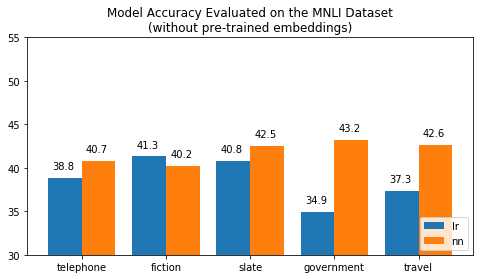

In [82]:
ax = df.T.plot(kind='bar', title='Model Accuracy Evaluated on the MNLI Dataset\n(without pre-trained embeddings)', 
               figsize=(8, 4), width=0.8, ylim=(30,55), rot=0)
ax.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], xy=(p.get_x()+0.05, p.get_height()+1))

In [83]:
df

,telephone,fiction,slate,government,travel
lr,38.806,41.3065,40.8184,34.9409,37.3727
nn,40.796,40.201,42.515,43.2087,42.668


# 3.3 Fine-tuning on MultiNLI
pick the best model over either NN or LR

In [6]:
SAVE_FOLDER = os.path.join('models', 'mnli')
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [9]:
for genre in all_genre:
    print('*'*30, genre, '*'*30)
    best_model = nn_best_model
    optimizer = optimizer_nn
    token2id = token2id_nn
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(best_model.parameters(), lr = LEARNING_RATE)
    train_loader, val_loader = get_data_loaders(genre, token2id)
    train_model(best_model, train_loader, val_loader, 
                     optimizer, criterion, n_epochs=10, save_file=SAVE_FOLDER+'/'+genre+'_model.pt')

****************************** telephone ******************************
Starting epoch 0
End of epoch 1, Training Acc: 48.78220140515222,Validation Acc: 41.492537313432834, Time: 3.4691269397735596 sec
New best model found, saving at models/mnli/telephone_model.pt

Starting epoch 1
End of epoch 2, Training Acc: 57.49414519906323,Validation Acc: 43.38308457711443, Time: 6.784811019897461 sec
New best model found, saving at models/mnli/telephone_model.pt

Starting epoch 2
End of epoch 3, Training Acc: 64.77751756440281,Validation Acc: 43.98009950248756, Time: 10.35728406906128 sec
New best model found, saving at models/mnli/telephone_model.pt

Starting epoch 3
End of epoch 4, Training Acc: 71.21779859484778,Validation Acc: 43.78109452736319, Time: 14.20176887512207 sec

Starting epoch 4
End of epoch 5, Training Acc: 76.7447306791569,Validation Acc: 42.885572139303484, Time: 18.123410940170288 sec

Starting epoch 5
End of epoch 6, Training Acc: 81.1943793911007,Validation Acc: 44.27860696

In [40]:
telephone_model = NeuralNetwork(embed_layer, embed_dim, NUM_CLASS, HIDDEN_DIM, 'SUB')
telephone_model.load_state_dict(torch.load(SAVE_FOLDER+'/telephone_model.pt'))

fiction_model = NeuralNetwork(embed_layer, embed_dim, NUM_CLASS, HIDDEN_DIM, 'SUB')
fiction_model.load_state_dict(torch.load(SAVE_FOLDER+'/fiction_model.pt'))

slate_model = NeuralNetwork(embed_layer, embed_dim, NUM_CLASS, HIDDEN_DIM, 'SUB')
slate_model.load_state_dict(torch.load(SAVE_FOLDER+'/slate_model.pt'))

government_model = NeuralNetwork(embed_layer, embed_dim, NUM_CLASS, HIDDEN_DIM, 'SUB')
government_model.load_state_dict(torch.load(SAVE_FOLDER+'/government_model.pt'))

travel_model = NeuralNetwork(embed_layer, embed_dim, NUM_CLASS, HIDDEN_DIM, 'SUB')
travel_model.load_state_dict(torch.load(SAVE_FOLDER+'/travel_model.pt'))

<All keys matched successfully>

In [41]:
finetuned_models = {'telephone_model': telephone_model, 
                    'fiction_model': fiction_model, 
                    'slate_model': slate_model, 
                    'government_model': government_model, 
                    'travel_model': travel_model}

In [42]:
df = pd.DataFrame(index=finetuned_models, columns=all_genre)
for model_type, model in finetuned_models.items():
    for genre in all_genre:
        _, val_loader = get_data_loaders(genre, token2id)
        val_acc = acc(val_loader, model)
        df[genre][model_type] = val_acc

In [43]:
df

,telephone,fiction,slate,government,travel
telephone_model,45.6716,43.5176,43.3134,45.5709,43.5845
fiction_model,45.0746,44.3216,44.7106,45.2756,43.0754
slate_model,44.8756,43.1156,45.2096,45.8661,46.0285
government_model,43.4826,46.0302,45.01,50.4921,45.2138
travel_model,46.1692,45.5276,46.507,49.311,45.6212


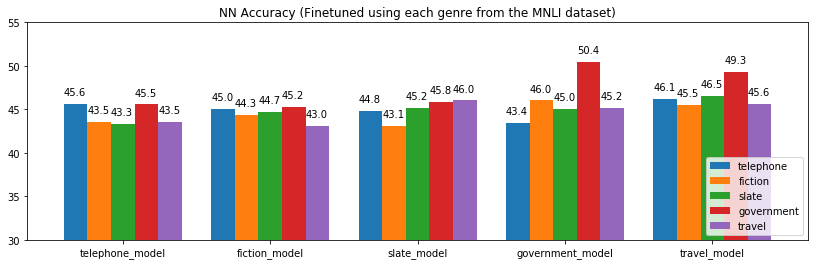

In [44]:
ax = df.plot(kind='bar', title='NN Accuracy (Finetuned using each genre from the MNLI dataset)', 
             figsize=(14, 4), width=0.8, ylim=(30,55), rot=0)
ax.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], xy=(p.get_x(), p.get_height()+1))

The finetuned models are uploaded to [this gdrive folder](https://drive.google.com/drive/folders/1TRwEd7O2ifC72eBJBJ1-zTBfG0nUC1tF?usp=sharing).

In [59]:
df_individual = pd.DataFrame([df['telephone']['telephone_model'], 
                              df['fiction']['fiction_model'], 
                              df['slate']['slate_model'], 
                              df['government']['government_model'], 
                              df['travel']['travel_model']], index=all_genre, columns=['nn'])

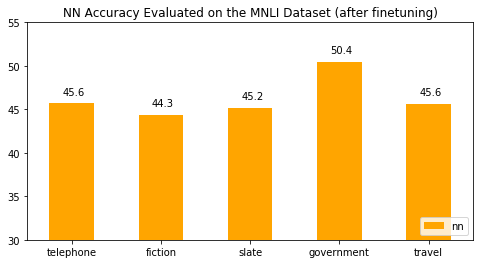

In [73]:
ax = df_individual.plot(kind='bar', title='NN Accuracy Evaluated on the MNLI Dataset (after finetuning)', 
             figsize=(8, 4), width=0.5, ylim=(30,55), rot=0, color='orange')
ax.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], xy=(p.get_x()+0.15, p.get_height()+1))